# <font color='violet'> Exploration & Parsing
Using prescription drug review data wrangled here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/1-kl-wrangle-tabular.ipynb

In [1]:
# ! pip install tqdm 
# !{sys.executable} -m pip install contractions

In [2]:
import numpy as np
import pandas as pd
import sys
import contractions
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [86]:
# prepare to add local python functions; import modules from src directory
src = '../src'
sys.path.append(src)

# import local functions
from nlp.parse import remove_accented_chars, strip_most_punc, strip_apostrophe

ImportError: cannot import name 'strip_non_emoji_emoji_symbol' from 'nlp.parse' (/Users/admin/Documents/GitHub/psychedelic_efficacy/notebooks/../src/nlp/parse.py)

In [4]:
df = pd.read_csv('../data/interim/studies_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50652 non-null  int64  
 1   drug        50652 non-null  object 
 2   rating      50652 non-null  float64
 3   condition   50652 non-null  object 
 4   review      50652 non-null  object 
 5   date        50652 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [5]:
# Drop "Unnamed" column; it's redundant with the index
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,drug,rating,condition,review,date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,0
1,dextroamphetamine,8.0,add,Switched from Adderall to Dexedrine to compare...,0


<font color='violet'> Explore each column, starting with 'drug'

In [6]:
# How many drugs are in the data? 
len(df.drug.unique())

651

In [7]:
# Which drugs are most commonly reviewed?
freq_drugs = df.drug.value_counts().head(10)
freq_drugs

Sertraline      1855
Escitalopram    1714
Citalopram      1298
Bupropion       1278
Lexapro         1232
Venlafaxine     1212
Varenicline     1082
Zoloft          1075
Quetiapine      1065
Clonazepam      1004
Name: drug, dtype: int64

It would be best to add a 'drug class' column when I come to feature engineering so that all these drugs are categorized. That column existed previously but came from one of the origina tables where too few of the rows had reviews for psych meds. I could eventually do this by creating a dictionary of drugs and their classes using information scraped from this website: https://www.drugs.com/drug-classes.html

Alternatively, drugs could be understood by the conditions they treat. 

<font color='violet'> Explore conditions

In [8]:
len(df.condition.unique())

38

In [9]:
freq_conditions = df.condition.value_counts().head(10)
freq_conditions

depression                  14425
anxiety                     14114
bipolar                      5604
addiction                    5192
insomnia                     5018
hrt                          1456
schizophrenia                 789
ocd                           752
other                         592
schizoaffective disorder      523
Name: condition, dtype: int64

In [10]:
# Which of the most common drugs are used to treat which of the most common conditions?

freq_drugs = ['Sertraline', 'Escitalopram', 'Citalopram', 'Bupropion', 'Lexapro', 
             'Venlafaxine', 'Varenicline', 'Zoloft', 'Quetiapine', 'Clonazepam']
freq_conditions = ['depression', 'anxiety', 'bipolar', 'addiction', 'insomnia', 'hrt',
                  'schizophrenia', 'ocd', 'other', 'schizoaffective disorder']
freq_drug_conditions = df[df['drug'].isin(freq_drugs) & df['condition'].isin(freq_conditions)]

freq_drug_conditions.head()

,drug,rating,condition,review,date
118,Clonazepam,10.0,anxiety,"""klonopin has definitely given me my life back...","April 19, 2008"
120,Escitalopram,9.0,depression,"""I am a 22 year old female college student. I ...","April 29, 2014"
124,Clonazepam,6.0,anxiety,"""Works for me""","March 24, 2013"
127,Zoloft,1.0,depression,"""Zoloft did not help me at all. I was on it f...","January 14, 2013"
129,Sertraline,10.0,depression,"""I had major depression from the time I starte...","November 2, 2014"


In [11]:
freq_combo_summary = freq_drug_conditions.pivot_table(index='condition', columns='drug', 
                                                    aggfunc='count', values='review')
freq_combo_summary.columns = freq_drugs
freq_combo_summary = freq_combo_summary.sort_values(by=freq_drugs, ascending=False)
freq_combo_summary

,Sertraline,Escitalopram,Citalopram,Bupropion,Lexapro,Venlafaxine,Varenicline,Zoloft,Quetiapine,Clonazepam
condition,,,,,,,,,,
depression,893.0,536.0,NaN,566.0,443.0,131.0,763.0,NaN,692.0,464.0
addiction,199.0,NaN,17.0,NaN,NaN,NaN,NaN,1079.0,NaN,NaN
anxiety,85.0,709.0,782.0,1061.0,751.0,100.0,841.0,NaN,432.0,441.0
bipolar,41.0,8.0,77.0,33.0,25.0,396.0,32.0,NaN,51.0,11.0
other,5.0,5.0,7.0,5.0,NaN,7.0,4.0,3.0,5.0,NaN
hrt,3.0,14.0,NaN,8.0,3.0,NaN,36.0,NaN,3.0,30.0
ocd,NaN,21.0,2.0,35.0,10.0,17.0,105.0,NaN,12.0,80.0
insomnia,NaN,NaN,103.0,NaN,NaN,243.0,NaN,NaN,NaN,NaN
schizoaffective disorder,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN


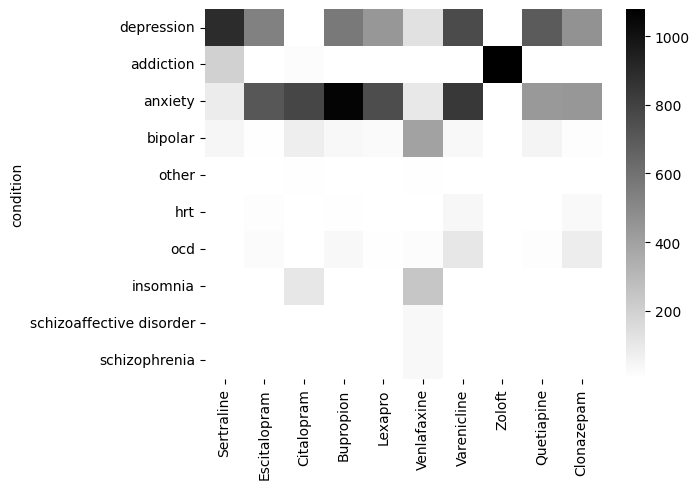

In [12]:
# Visualize distribution of reviews across common conditions & drugs with a heatmap.
sns.heatmap(freq_combo_summary, cmap='gray_r')
plt.show()

<font color='violet'> Which drugs & conditions have the highest ratings?

In [13]:
top_drugs = df.groupby(['drug'])['rating'].mean().sort_values(ascending=False)
top_drugs.head(80)

drug
Hydrochlorothiazide / olmesartan    10.000000
Undecylenic acid                    10.000000
Vivelle                             10.000000
Focalin XR                          10.000000
lorazepam                           10.000000
                                      ...    
Micrainin                           10.000000
Tiagabine                           10.000000
Seconal Sodium                      10.000000
Propofol                            10.000000
Alprazolam Intensol                  9.833333
Name: rating, Length: 80, dtype: float64

In [14]:
successful_conditions = df.groupby(['condition'])['rating'].mean().sort_values(
    ascending=False)
successful_conditions.head(10)

condition
sad                  9.421053
failure to thrive    9.333333
did                  9.000000
addiction            8.686826
eating disorder      8.209302
ocd                  8.082447
nightmares           8.000000
other                7.939189
anxiety              7.750531
ptsd                 7.685185
Name: rating, dtype: float64

In [15]:
top_combo = df.groupby(['drug', 'condition'])['rating'].mean().sort_values(
    ascending=False)
top_combo.head(140)

drug                 condition 
Effexor              asd           10.000000
Asendin              depression    10.000000
Niravam              depression    10.000000
dextrostat           add           10.000000
Tofranil             nightmares    10.000000
                                     ...    
Evzio                addiction     10.000000
Pseudoephedrine      other         10.000000
Pristiq              hrt           10.000000
Methadone            other          9.875000
Alprazolam Intensol  anxiety        9.833333
Name: rating, Length: 140, dtype: float64

In [16]:
top_freq_drugs = set(freq_drugs).intersection(set(top_drugs.index[0:79]))
top_freq_drugs

set()

In [17]:
top_freq_drugs_by_condition = set(freq_drugs).intersection(set(top_combo.index[0:138]))
top_freq_drugs_by_condition

set()

In [18]:
successful_freq_conditions = set(freq_conditions).intersection(set(
    successful_conditions.index[0:10]))
successful_freq_conditions

{'addiction', 'anxiety', 'ocd', 'other'}

Anxiety, addction, and ocd are conditions for which there are many drug reviews and high rates of success with treatment. 

The 10 most frequently-reviewed drugs have nothing in common with the 79 perfectly-rated drugs or the 138 drugs that are rated perfectly for any single condition. My hypothesis is that these drugs may have only one or very few reviews each, which is how their average rating is so high. 

<font color='violet'> Explore distribution of ratings

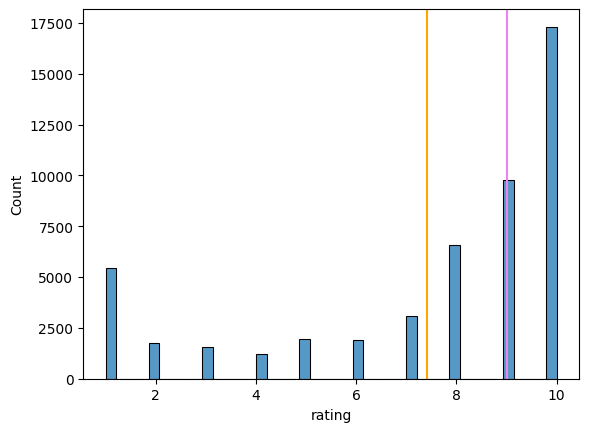

In [19]:
sns.histplot(df.rating)
plt.axvline(df.rating.mean(), color='orange')
plt.axvline(df.rating.median(), color='violet')
plt.show()

More participants gave their drug a high review than gave low reviews, and even fewer gave mediocre reviews.

Now, find out: of drugs that received an average rating of 10, how many reiews is that mean derived from?

In [20]:
perfect_avg_rating = set(top_drugs.index[0:79])
df[df.drug.isin(perfect_avg_rating)].value_counts(subset='drug')[0:17]

drug
Secobarbital         6
Estratest H.S.       5
Magnesium citrate    4
Seconal              3
Estropipate          3
Seconal Sodium       3
Diazepam Intensol    3
Focalin XR           3
Cenestin             3
Tranxene SD          2
Ciprofloxacin        2
Eskalith-CR          2
Ogen                 2
Vivelle              2
Isotretinoin         2
chantix              2
Regadenoson          1
dtype: int64

Of the 79 drugs with perfect average ratings, only 16 of them had more than one rating, and only 3 of them had more than 3 ratings. Given that there are about 50500 ratings and 650 drugs, the average number of ratings per drug is about 80, so the perfectly-rated drugs definitely seem like outliers. I'd not be surprised if a model eventually has a difficult time correctly classifying the extreme ratings, but for now I'll just keep this in mind and see what happens. 

<font color='violet'> What does the distribution of ratings look like for drugs with at least 20 ratings (20 = 25% of the average number of ratings)?

In [21]:
df['ratings_count'] = df.groupby(['drug'])['drug'].transform('count')
df.sort_values('ratings_count')

,drug,rating,condition,review,date,ratings_count
19385,Silver sulfadiazine,9.0,other,"""Works well, but I get a bit short of breath a...","July 1, 2016",1
44539,Brisdelle,7.0,hrt,"""I have been on Brisdelle for 3 yrs now at fir...","August 24, 2016",1
44568,Dimethyl sulfoxide,10.0,other,"""I have used DMSO for many things related to p...","March 13, 2013",1
35596,Cholestyramine,10.0,other,"""I have used this for 1 year and have no side ...","February 26, 2011",1
9404,Hydrocortisone / neomycin / polymyxin b,1.0,other,"""I went to my doctor for earache relief and I ...","May 29, 2016",1
...,...,...,...,...,...,...
45820,Sertraline,10.0,anxiety,"""Worked wonders for me. Changed my life. I hav...","July 15, 2008",1855
11268,Sertraline,8.0,anxiety,"""I am on day 16 of 50mg and I am starting to f...","January 6, 2015",1855
29321,Sertraline,10.0,hrt,"""I was on Lexapro for almost 5 years for depre...","February 3, 2013",1855
43521,Sertraline,2.0,depression,"""I started taking this medicine over a week ag...","September 20, 2016",1855


In [22]:
twenty_plus_ratings = df[df.ratings_count>=20]
twenty_plus_ratings.sort_values('ratings_count')

,drug,rating,condition,review,date,ratings_count
20018,Budeprion XL,9.0,depression,"""I have been using Budeprion for about 3 month...","November 19, 2011",20
19072,Angeliq,10.0,hrt,"""I am 59 years old. I had all the symptoms of ...","October 27, 2016",20
19312,Memantine,1.0,alzheimers,"""My wife began the 4 stage process a couple of...","June 27, 2014",20
49228,Drospirenone / estradiol,10.0,hrt,"""Well it changed my life. I was only 43 and ev...","December 12, 2008",20
40570,Drospirenone / estradiol,2.0,hrt,"""Lots of side effects especially breast pain a...","January 5, 2016",20
...,...,...,...,...,...,...
19675,Sertraline,10.0,anxiety,"""My 18 year old son was diagnosed with panic d...","December 8, 2014",1855
34582,Sertraline,8.0,ptsd,"""As someone that HATES crowds &amp; dealing wi...","November 12, 2015",1855
29253,Sertraline,8.0,anxiety,"""Having suffered with severe depression &amp; ...","May 7, 2017",1855
34578,Sertraline,8.0,depression,"""I started taking this drug to battle mild dep...","July 29, 2016",1855


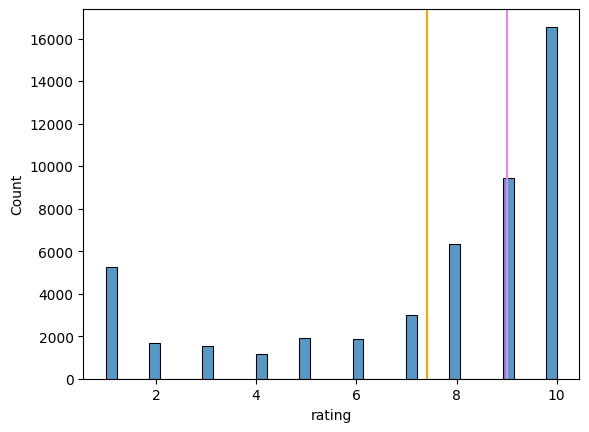

In [23]:
sns.histplot(twenty_plus_ratings.rating)
plt.axvline(df.rating.mean(), color='orange')
plt.axvline(df.rating.median(), color='violet')
plt.show()

This distribution doesn't look much different from that which includes all reviews, which tells me the outliers aren't affecting the distribution too much. So it's probably a good idea to keep all rows in the dataset when moving forward.  

<font color='violet'> What is the relationship between date and reviews?

In [24]:
df.date.unique()

array(['0', 'February 28, 2012', 'October 18, 2016', ...,
       'January 13, 2009', 'December 12, 2017', 'December 12, 2009'],
      dtype=object)

In [25]:
df.date = df.date.replace('0', np.nan)
df.date

0                      NaN
1                      NaN
2                      NaN
3                      NaN
4                      NaN
               ...        
50647    November 10, 2016
50648        July 17, 2016
50649      August 16, 2016
50650     January 21, 2015
50651         May 31, 2015
Name: date, Length: 50652, dtype: object

In [26]:
df.date = pd.to_datetime(df.date)
df.date

0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
50647   2016-11-10
50648   2016-07-17
50649   2016-08-16
50650   2015-01-21
50651   2015-05-31
Name: date, Length: 50652, dtype: datetime64[ns]

In [27]:
# Are there more or fewer reviews from any given point in time?
df['count_by_date'] = df.groupby(['date'])['date'].transform('count')
unique_dates = df.drop_duplicates(subset=['date'])
unique_dates.head()

,drug,rating,condition,review,date,ratings_count,count_by_date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
109,Mirtazapine,10.0,depression,"""I&#039;ve tried a few antidepressants over th...",2012-02-28,719,20.0
110,Methadone,7.0,addiction,"""Ive been on Methadone for over ten years and ...",2016-10-18,181,37.0
111,Seroquel,10.0,schizoaffective disorder,"""No problems, watch what you eat.""",2014-10-08,417,21.0
112,Ambien,2.0,insomnia,"""Ditto on rebound sleepless when discontinued....",2015-01-13,381,8.0


In [28]:
df.describe()

,rating,ratings_count,count_by_date
count,50652.000000,50652.000000,50543.000000
mean,7.412501,660.981245,19.495222
std,3.075669,484.434979,9.489709
min,1.000000,1.000000,1.000000
25%,6.000000,245.000000,12.000000
50%,9.000000,596.000000,18.000000
75%,10.000000,1004.000000,26.000000
max,10.000000,1855.000000,55.000000


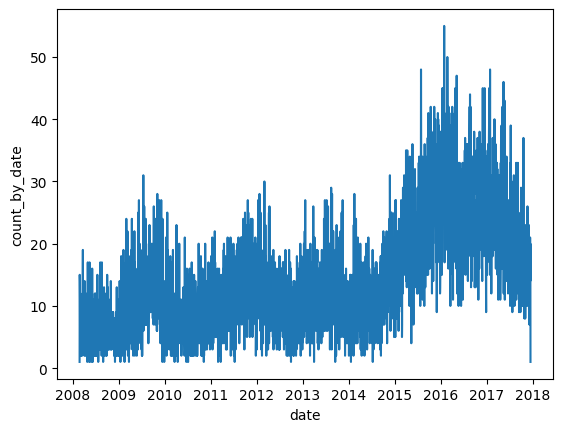

In [29]:
sns.lineplot(data=unique_dates, x='date', y='count_by_date')
plt.show()

There was an increase in the number of reviews submitted daily around 2015. 

<font color='violet'> Do ratings change with time?

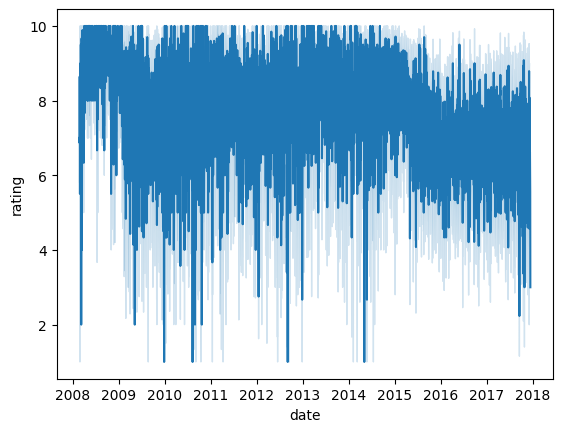

In [30]:
sns.lineplot(data=df, x='date', y='rating')
plt.show()

This looks like something other than total random noise, like maybe there were some current events happening around 2009 and again in 2015 that led people to start rating their psych meds less favorably. There may also be some annual seaonality. Whatever the reason, it seems that date could be correlated with rating and should not be removed. Process this column further to better understand the relationship between date and rating. 

In [31]:
rating_date = df[['date', 'rating']].dropna().set_index('date')
rating_date

,rating
date,
2012-02-28,10.0
2016-10-18,7.0
2014-10-08,10.0
2015-01-13,2.0
2015-02-14,10.0
...,...
2016-11-10,9.0
2016-07-17,2.0
2016-08-16,9.0


<AxesSubplot: xlabel='date'>

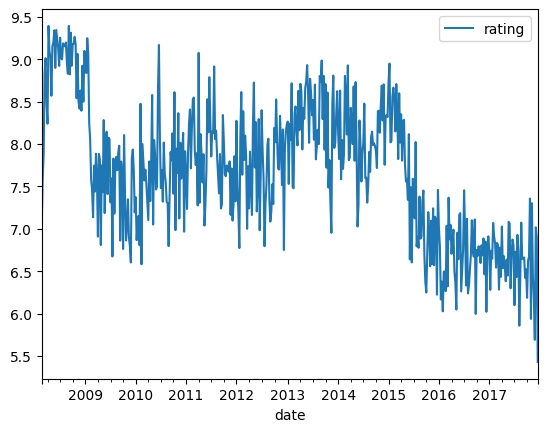

In [32]:
downsample_week = rating_date.resample('W').mean()
downsample_week.plot()

<AxesSubplot: xlabel='date'>

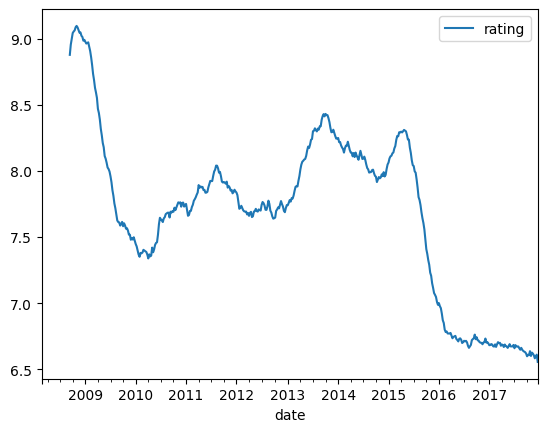

In [33]:
rolling_mean = downsample_week.rolling(window=30).mean()
rolling_mean.plot()

<AxesSubplot: xlabel='date'>

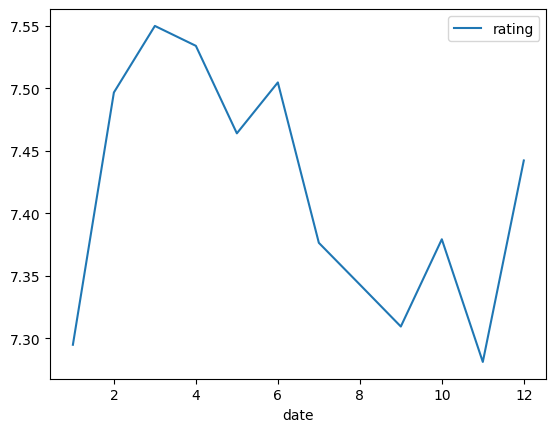

In [34]:
# Check for seasonality
index_month = rating_date.index.month
rating_by_month = rating_date.groupby(index_month).mean()
rating_by_month.plot()

It seems that seasonal variation is less extreme than variation by year (average range of 7.3-7.55 instead of 6.5-9.0), with people rating their drugs as being, on average, very slightly less effective in July-November. 

It is even more clear now that weekly average ratings of drugs in these studies did in facat dip in 2009 and again in 2015. The purpose behind these trends isn't so important (though I have some guesses as to what was happening in 2009 and 2015). The date, though, will be a valuable variable alongside narrataive text features when predicting ratings, so as to compare like with like current-events wise. 

Now, move from the more quantitative data into the narrative column, cleaning up language therein. 

<font color='violet'> Parse Language
    
The review column contains narratives where patients explain their experience with a prescription psych med. Language features from that column need to be extracted or created after any necessary cleaning of strings has been completed. Do any preparations necessary to conduct sentiment analysis. I'll be drawing quite a bit from the following resource: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [35]:
# View a sample string. Search for special characters.
df.review[0]

'I had began taking 20mg of Vyvanse for three months and was surprised to find that such a small dose affected my mood so effectively.  When it came to school work though I found that I needed the 30mg to increase my level of focus (and have been on it for a month since).  I had not experienced decreased appetite until about a month into taking the 20mg.  I find that the greatest benefit of Vyvanse for me is that it tends to stabalize my mood on a daily basis and lessens any bouts of anxiety and depression that i used to face before I was perscribed. a few experiences of nausiea, heavy moodswings on the days I do not take it, decreased appetite, and some negative affect on my short-term memory. My mood has noticably improved, I have more energy, experience better sleep and digestion.'

In [36]:
df[df['review'].str.find("é")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date


In [37]:
df[df['review'].str.find("ä")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date


<font color='violet'> Remove Special Characters

...if there are any. Haven't been able to find any of the most common special characters é or ä in the data, but doing it just in case. 

In [38]:
# This function works in the test suite, but there may not be examples in the data
df['review'] = df['review'].apply(remove_accented_chars)

<font color='violet'> Expand Contractions

In [39]:
# First, find some to confirm it works. 
df[df['review'].str.find("'")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date
9,concerta,8.0,adhd,The treatment details were pretty basic. I ju...,NaT,13,NaN


In [40]:
df.review[9]

"The treatment details were pretty basic.  I just took the medication in the morning at the same time of day every day.  I was allowed to skip it on the weekends or less busy times if I so desired.  I really don't have anything else to put for this section of the survey.  I'm trying to fill up the 50 word requirement though.  You shouldn't really have that requirement on this form.  It seems kind of silly to be writing with nothing left to say. Some of the side affects that I had were:  my stomach would hurt sometimes and other times it was difficult to eat without getting queezy.  I didn't have much of an appetite.  When the medicine wore off, it seemed to have a strong rebound effect and things became difficult for me during that last several hours of my day. I liked taking the medication, I just wish it would have lasted longer during the day.  By 3p-5pm it had wore off and that seemed to by my busiest time of day with the kids, dinner and house stuff all at once. I did not have any

In [41]:
df['review'] = df['review'].apply(contractions.fix)
df.review[9]

'The treatment details were pretty basic.  I just took the medication in the morning at the same time of day every day.  I was allowed to skip it on the weekends or less busy times if I so desired.  I really do not have anything else to put for this section of the survey.  I am trying to fill up the 50 word requirement though.  You should not really have that requirement on this form.  It seems kind of silly to be writing with nothing left to say. Some of the side affects that I had were:  my stomach would hurt sometimes and other times it was difficult to eat without getting queezy.  I did not have much of an appetite.  When the medicine wore off, it seemed to have a strong rebound effect and things became difficult for me during that last several hours of my day. I liked taking the medication, I just wish it would have lasted longer during the day.  By 3p-5pm it had wore off and that seemed to by my busiest time of day with the kids, dinner and house stuff all at once. I did not have

"Don't" got changed to "do not"; contraction expansion worked. 

<font color='violet'> Next, remove punctuation/special characters where appropriate. 
    
Try to keep those correlated with sentiment: ! ? # % ;) :( .  Again, first find an example to confirm it works.

In [42]:
df[df['review'].str.find("!")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN


In [43]:
df.review[6]

'So far the throwing up has stopped and the headaches come and go no food even looks good to eat no cravings very easy to diet ;) and passing all my finals was AMAZING. This drug makes strattera look like tylenol! throwing up alot, bad headaches, twitching, crazy heart beat, loss of appetite (which is a plus in my eyes), and happy thoughts (like "wow i am soo beautiful" for some reason would pop in my head alot), as well as some negative thoughts and worrying about homework constantly which is fine to because i would get it all done. I needed to switch from straterra which made me very very depressed quiet and i slept for like an hour each night with that drug it was horrible. I switched to Vyvanse and the first time i took it, it was like an anti deppresant at first i was the normal happy hyper me but i could still focus very well on studying but when i started comming down from it that was the worst i was dry heaving with a TERRIBLE HEADACHE for an hour and then i would just throw ev

In [44]:
# Use function from package I made to get rid of most of the punctuation.
strip_most_punc(df, 'review')
df.review[6]

100%|██████████| 50652/50652 [01:01<00:00, 818.16it/s] 


'So far the throwing up has stopped and the headaches come and go no food even looks good to eat no cravings very easy to diet ;) and passing all my finals was AMAZING This drug makes strattera look like tylenol! throwing up alot bad headaches twitching crazy heart beat loss of appetite (which is a plus in my eyes) and happy thoughts (like wow i am soo beautiful for some reason would pop in my head alot) as well as some negative thoughts and worrying about homework constantly which is fine to because i would get it all done I needed to switch from straterra which made me very very depressed quiet and i slept for like an hour each night with that drug it was horrible I switched to Vyvanse and the first time i took it it was like an anti deppresant at first i was the normal happy hyper me but i could still focus very well on studying but when i started comming down from it that was the worst i was dry heaving with a TERRIBLE HEADACHE for an hour and then i would just throw everything up 

In [45]:
# left to strip are ' and : ; () where they don't appear as emoji.

df[df['review'].str.find("'")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date
16,adderall,8.0,add,Diagnosed with Adult ADD I first took Ritalin ...,NaT,13,NaN


In [46]:
df.review[16]

"Diagnosed with Adult ADD I first took Ritalin I found this to cause some 'nervousness' and to have peaks  valleys I switched to Adderall XR and find I notice no physical symptoms only an increase in positive mood and desire to accomplish the days work The effect does seem to peak soon after the dose slowly level out and at about 68 hrs after initial dose I feel calm but now enthusiastic as earlier in the day None noticeable Increased interest and enthusiasm in activities"

In [47]:
strip_apostrophe(df, 'review')
df.review[16]

100%|██████████| 50652/50652 [01:13<00:00, 688.19it/s] 


'Diagnosed with Adult ADD I first took Ritalin I found this to cause some nervousness and to have peaks  valleys I switched to Adderall XR and find I notice no physical symptoms only an increase in positive mood and desire to accomplish the days work The effect does seem to peak soon after the dose slowly level out and at about 68 hrs after initial dose I feel calm but now enthusiastic as earlier in the day None noticeable Increased interest and enthusiasm in activities'

Stripping apostrophes worked. 

<font color='violet'> Zero in on characters that are commonly used in emoji and remove them where they don't appear as part of an emoticon. 
    
Now remove :;() when they appear next to a letter, not emoji. This isn't a perfect solution, as many characters that I already removed can get used in emoji, but at least the most common emoji will be preserved. I'm not going to search for places where these appear next to numbers because my assumption is that symbols appear next to numbers more often as emoji, compared with letters which appear more often next to symbols used for basic punctuation. 
    
Row 6 from earlier has an emoji ;) as well as other ( and ) symbols. Where might I find some other : and ; to see if I'm successfully removing them?

In [66]:
df[df['review'].str.find(":")!=-1].head(1)

,drug,rating,condition,review,date,ratings_count,count_by_date
13,strattera,8.0,add,With or without this medication I am a philoso...,NaT,17,NaN


In [67]:
df.review[13]

'With or without this medication I am a philosopher So I will be explain how the drug works on me from a philosophical assessment\r\r\n\r\r\nBackground:\r\r\nI had taken Strattera for three years (20052007) where it helped control ADD where I had difficulty doing so It helped me focus stay organized manage relations and most or all of the benefits I listed prior I dropped the drug for 3 years so that I may learn how to control my ADD without the help of medication During those three years I gained remarkable self control in overcoming ADD However I got to the point where I could not win over ADD which was losing focus randomly During college lectures that I found very intriguing I would often zone outspace out when I could not have been more interested in what was being professed The frustration of this led me to conclude that medical assistance was the best choice\r\r\n\r\r\nOn the drug:\r\r\nI read and understand that the erally biggest conside effectto this drug is that there is som

In [75]:
# That example has lots of weird stuff going on; deal with that eventually if necessary.
# For now I can at lease see where the : is (row 2) and check if my function below delets it
# Finally, find an example of ;

df[df['review'].str.find(";")!=-1].head(8)

,drug,rating,condition,review,date,ratings_count,count_by_date
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN
7,ritalin-la,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,1,NaN
8,wellbutrin-sr,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,2,NaN
9,concerta,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,13,NaN
10,concerta,2.0,adhd,So far the throwing up has stopped and the hea...,NaT,13,NaN
11,strattera,8.0,add,So far the throwing up has stopped and the hea...,NaT,17,NaN
12,vyvanse,10.0,adhd,So far the throwing up has stopped and the hea...,NaT,21,NaN
78,strattera,7.0,adhd,Best way I have discovered to eliminate the si...,NaT,17,NaN


In [76]:
# Yikes, I'm glad I discovered those duplicate reviews; deal with that shortly
df.review[78]

'Best way I have discovered to eliminate the side effects is to eat a proteinrich breakfast ally egghamcheese sandwich for me then WAIT for at least a few minutes anywhere from 15 to 60 or more before taking the medication Seems to retain efficacy COMPLETELY eliminate stomach problems and GREATLY reduce grogginess though that also seems to be partly dependent on how much sleep I get imum of 6 hours preferably 8 or 9) Now that I discovered this trick I am feeling MUCH better and no longer considering abandoning the medication! I like that it helps with sleeping quality on top of helping me focus remember and feel more aware of surroundings Would cry now if I had to go back to not using it  I almost cannot function without medication and the nonstimulant allows me to sleep SO much better and I do not crash from it! Severe grogginess often accompanied by lightheadedness upset stomachnausea  ALL aggravated by sleep loss or lack of food become slightly less severe after I would been on it a

In [79]:
# Note: the ; in that last example above shows up in the third to last row.

# Use a function that can remove these characters appropriately
# I'd like to include this in my nlp.parse package, but the import isn't working
# Not sure why (other functions imported fine), so I'll just leave it here for now. 

def strip_non_emoji_emoji_symbol(df, column):
    # Isolate 1 narrative at a time
    for row in tqdm(range(len(df))):
        string_to_strip = df.loc[row,column]
        
        # Find each ) that appears next to letters, not other symbols.
        closing_parentheses = [m.end() for m in re.finditer('[a-zA-z]\)', string_to_strip)]
        # That's not capturing the correct character. Fix this.
        clos_parenth_indices = [n - 1 for n in closing_parentheses]
        # Find each (
        opening_parentheses = [m.start() for m in re.finditer('\([a-zA-z]', string_to_strip)]
        # Find each :
        colon_after_word = [m.end() for m in re.finditer('[a-zA-z]\:', string_to_strip)]
        colon_after_indices = [n - 1 for n in colon_after_word]
        colon_before_word = [m.start() for m in re.finditer('\:[a-zA-z]', string_to_strip)]
        # find each ;
        semicolon_after_word = [m.end() for m in re.finditer('[a-zA-z]\;', string_to_strip)]
        semicolon_after_indices = [n - 1 for n in semicolon_after_word]
        semicolon_before_word = [m.start() for m in re.finditer('\;[a-zA-z]', string_to_strip)]

        # Combine lsits of indices in order to replace all characters
        indices_to_remove = clos_parenth_indices + opening_parentheses + colon_after_indices \
        + colon_before_word + semicolon_after_indices + semicolon_before_word
        
        # Replace target characters in the string to strip with just a space ' '
        # Use a space ' ' instead of nothing '' in case of something like:this
        temp = list(string_to_strip)
        for index in indices_to_remove:
            temp[index] = ' '
            result = ''.join(temp)
            new_string = str(result)
        # This returns nothing if there were no symbols to replace so provide alternative
        try: df.loc[row,column] = new_string
        except: df.loc[row,column] = string_to_strip
                        
strip_non_emoji_emoji_symbol(df,'review')

df.review[6]

100%|██████████| 50652/50652 [01:11<00:00, 708.37it/s]


'With or without this medication I am a philosopher So I will be explain how the drug works on me from a philosophical assessment\r\r\n\r\r\nBackground \r\r\nI had taken Strattera for three years (20052007) where it helped control ADD where I had difficulty doing so It helped me focus stay organized manage relations and most or all of the benefits I listed prior I dropped the drug for 3 years so that I may learn how to control my ADD without the help of medication During those three years I gained remarkable self control in overcoming ADD However I got to the point where I could not win over ADD which was losing focus randomly During college lectures that I found very intriguing I would often zone outspace out when I could not have been more interested in what was being professed The frustration of this led me to conclude that medical assistance was the best choice\r\r\n\r\r\nOn the drug \r\r\nI read and understand that the erally biggest conside effectto this drug is that there is som

In [49]:
# The ;) is intact, but all other parentheses that had been in the string from row 6 are gone!
# Check on the two other strings.
df.review[13]

'So far so good ;) passing all my finals (like wow (really'

In [80]:
df.review[78]

'Best way I have discovered to eliminate the side effects is to eat a proteinrich breakfast ally egghamcheese sandwich for me then WAIT for at least a few minutes anywhere from 15 to 60 or more before taking the medication Seems to retain efficacy COMPLETELY eliminate stomach problems and GREATLY reduce grogginess though that also seems to be partly dependent on how much sleep I get imum of 6 hours preferably 8 or 9) Now that I discovered this trick I am feeling MUCH better and no longer considering abandoning the medication! I like that it helps with sleeping quality on top of helping me focus remember and feel more aware of surroundings Would cry now if I had to go back to not using it  I almost cannot function without medication and the nonstimulant allows me to sleep SO much better and I do not crash from it! Severe grogginess often accompanied by lightheadedness upset stomachnausea  ALL aggravated by sleep loss or lack of food become slightly less severe after I would been on it a

Symbol removal so far has worked well. I'm going to stop with that becaue I don't need perfection, just cleaner text than I started with so as to end up with fewer oddballs to deal with if I want to do something like making a bag of words. 

I do definitely want to figure out if there are a bunch of rows with duplicate reviews. It seems that what I discovered is one person may have just written one big review for all their drugs and entered it multiple times, with a different drug and rating each time. Is this behavior an outlier or are there other examples like this? 

In [99]:
df[df.review.duplicated()==True]

,drug,rating,condition,review,date,ratings_count,count_by_date
1,dextroamphetamine,8.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,3,NaN
2,vyvanse,8.0,adhd,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
3,saizen,8.0,fatigue,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
4,zyprexa,3.0,dementia,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
5,vyvanse,10.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
...,...,...,...,...,...,...,...
50647,Venlafaxine,9.0,anxiety,Had panic attacks and social anxiety starting ...,2016-11-10,1212,27.0
50648,Vortioxetine,2.0,depression,Had panic attacks and social anxiety starting ...,2016-07-17,681,18.0
50649,Ativan,9.0,anxiety,I was super against taking medication I#039 ve...,2016-08-16,282,42.0
50650,Fluoxetine,8.0,ocd,I was super against taking medication I#039 ve...,2015-01-21,950,12.0


The majority of rows actually contain duplicate reviews, each connected with multiple different drugs. Did the data start out this way, or did I make an error during wrangling?

In [89]:
drugs_dotcom_train = pd.read_csv('../data/raw/drugsComTrain_raw.tsv', sep='\t')
drugs_dotcom_test = pd.read_csv('../data/raw/drugsComTest_raw.tsv', sep='\t')
druglib_train = pd.read_csv('../data/raw/drugLibTrain_raw.tsv', sep='\t')
druglib_test = pd.read_csv('../data/raw/drugLibTest_raw.tsv', sep='\t')
psytar = pd.read_csv('../data/raw/PsyTAR_dataset_samples.csv')

In [113]:
# Make a function to help figure out what's going on 
def inspect_duplicate_reviews(df, column):
    df = df.sort_values(by=column)
    print(len(df), len(df[df[column].duplicated()==True]))
    return df[df[column].duplicated()==True].head()

# What my current working data looks like
inspect_duplicate_reviews(df, 'review')

50652 47239


,drug,rating,condition,review,date,ratings_count,count_by_date
43426,Paxil,8.0,depression,Reminder everyone#039 s experience is differe...,2011-04-15,592,20.0
43425,Lamotrigine,8.0,bipolar,Reminder everyone#039 s experience is differe...,2016-05-30,691,13.0
43424,Paroxetine,9.0,anxiety,Reminder everyone#039 s experience is differe...,2016-06-04,776,26.0
41322,Geodon,8.0,schizoaffective disorder,Reminder everyone#039 s experience is differe...,2012-11-01,221,10.0
41321,Bupropion,8.0,depression,Reminder everyone#039 s experience is differe...,2010-06-02,1278,8.0


In [114]:
# Check out each of the other raw datasets
drugs_dotcom_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161297 entries, 112607 to 110436
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 9.8+ MB


In [115]:
inspect_duplicate_reviews(drugs_dotcom_train, 'review')

161297 48968


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
73400,124699,Tri-Previfem,Birth Control,"""\r\nFirst of all, the worst side effect for m...",1.0,"September 12, 2017",2
145940,37325,Vyvanse,ADHD,"""\r\nGood. Concentration, happy, easy to talk ...",5.0,"October 17, 2015",10
5332,167112,Levonorgestrel,Birth Control,"""\r\nI got tired of taking the pill so I figur...",3.0,"June 8, 2016",1
33031,39621,Contrave,Obesity,"""\r\nMost insurance companies won&#039;t pay f...",8.0,"March 14, 2016",15
30158,79026,Plan B One-Step,Emergency Contraception,"""\r\nMy bf and I had a condom break and I pani...",7.0,"June 30, 2017",2


In [116]:
# 30% of the original reviews from that set were duplicates. 
inspect_duplicate_reviews(drugs_dotcom_test, 'review')

53766 5486


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
45612,113336,Bisacodyl,Constipation,"""\r\nHell no, never again! severe stomach cram...",1.0,"July 27, 2015",10
13632,88800,Necon 1 / 35,Endometriosis,""" I&#039;m on my 2nd round of necon 1/35. I st...",2.0,"July 8, 2016",5
37900,150121,Mucinex D,Cough and Nasal Congestion,""" It got rid of my cough but then made my nose...",1.0,"February 15, 2016",16
21080,142825,Levonorgestrel,Emergency Contraception,""" On May 18th this guy came completely inside ...",10.0,"July 5, 2017",6
10712,374,Medroxyprogesterone,Abnormal Uterine Bleeding,"""&quot;just stopped because I have been on it ...",10.0,"March 27, 2015",7


In [117]:
# 10% of drugs_dotcom_test was duplicates
druglib_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3107 non-null   object
 7   sideEffectsReview  3105 non-null   object
 8   commentsReview     3099 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [120]:
inspect_duplicate_reviews(druglib_train, 'commentsReview')

3107 59


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
1408,3024,cipro,10,Highly Effective,Mild Side Effects,rare kidney infection,My daughter is playing now finally and she see...,Blistering rash,.
249,1843,yasmin,10,Highly Effective,No Side Effects,birth control,"I've been on yasmin four years now, it works s...",None,.
2282,1922,zithromax,8,Highly Effective,Mild Side Effects,sinusitis,"It is extremely, powerful antibiotic, which gi...",nausea,500 mg of azithromycin once in a day...for thr...
2575,1894,doxycycline,10,Highly Effective,No Side Effects,severe peridontal disease,"I had persistent periodontal problems, both ...",None.,A dentist in my dental HMO prescribed it and w...
439,1660,climara,10,Highly Effective,Mild Side Effects,menopausal,Climara patch almost completely stopped the se...,The only side effect from the Climara is mild ...,After being miserable with frequent (20+ times...


In [122]:
# Fewer of these were duplicates
psytar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            891 non-null    int64  
 1   comment_index    891 non-null    int64  
 2   comment_id       891 non-null    int64  
 3   drug_id          891 non-null    object 
 4   rating           891 non-null    int64  
 5   disorder         891 non-null    object 
 6   side-effect      877 non-null    object 
 7   comment          768 non-null    object 
 8   gender           881 non-null    object 
 9   age              879 non-null    float64
 10  dosage_duration  888 non-null    object 
 11  date             891 non-null    object 
 12  category         891 non-null    object 
dtypes: float64(1), int64(4), object(8)
memory usage: 90.6+ KB


In [123]:
inspect_duplicate_reviews(psytar, 'comment')

891 124


,index,comment_index,comment_id,drug_id,rating,disorder,side-effect,comment,gender,age,dosage_duration,date,category
236,237,1412,18,zoloft.18,1,depression,"Weight gain (20lbs.), no sexual feelings at al...","At first, I din't realize all of these side ef...",F,24.0,9 months,2003-09-01 0:00:00,ssri
444,445,2289,13,cymbalta.13,1,depression,"nonstop headache, constipation, racing thought...",Bad Drug!,F,53.0,2 weeks,2006-06-25 0:00:00,snri
7,8,156,8,lexapro.8,1,depression/ anxiety,Extreme Weight Gain 30 pounds,NaN,M,16.0,1 years5 MG,2014-02-19 0:00:00,ssri
46,47,1793,47,lexapro.47,2,depression,weight gain,NaN,F,27.0,4 months,2006-05-16 0:00:00,ssri
50,51,574,51,lexapro.51,2,depression,Problems with memory. Inability to focus/conce...,NaN,F,66.0,7 weeks,2009-12-17 0:00:00,ssri


This last raw dataset has about 15% duplicate values but few rows overall. 

I did go back to the wrangling notebook and don't see any errors that would have caused this. I think I just didn't notice earlier because I would expect there to be duplicates in many of the columns (drug, condition) without it being a problem at all. Or perhaps completely duplicated rows, and took care of those. But it didn't cross my mind to think that specifically the reveiw column would have duplicates across multiple drugs. 

There are enough duplicated reviews in the raw data to account for all the duplicates in my current dataframe. My best working hypothesis is that the duplicate reviews appeared more often with psych meds because people may cycle through and try many drugs and then write up one big narrative to submit. Or perhaps, they feel one way about the drug's effects and go back to change their rating later, which results in two rows varying only by rating. I may need to more closely inspect each set of duplicates and find out which drugs the reviews are actually relevant for, removing the rest of the rows. 

<font color='violet'> Remove rows with irrelevant duplicated reviews

In [125]:
# Start with just one set of duplicates and see what I find.
df.head(8)

,drug,rating,condition,review,date,ratings_count,count_by_date
0,vyvanse,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
1,dextroamphetamine,8.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,3,NaN
2,vyvanse,8.0,adhd,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
3,saizen,8.0,fatigue,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
4,zyprexa,3.0,dementia,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
5,vyvanse,10.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN


It appears that somebody submitted the same review for vyvanse, dextroamphetamine, saizen, and zyprexa. And with vyvanse, they submitted it as being used to treat both add and adhd. And for add they gave it a rating of 9 with one submission and 10 with another. 

I can see already that this definitly pertains to vyvanse. Since the add ratings are ambiguous, I can just get rid of those and keep the row for adhd. 

In [127]:
df = df.drop(labels=[0,5])
df.head(6)

,drug,rating,condition,review,date,ratings_count,count_by_date
1,dextroamphetamine,8.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,3,NaN
2,vyvanse,8.0,adhd,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
3,saizen,8.0,fatigue,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
4,zyprexa,3.0,dementia,I had began taking 20mg of Vyvanse for three m...,NaT,1,NaN
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN


In [128]:
# Take a closer look at the full review to see if it pertains to the other drugs.
df.review[1]

'I had began taking 20mg of Vyvanse for three months and was surprised to find that such a small dose affected my mood so effectively  When it came to school work though I found that I needed the 30mg to increase my level of focus ( have been on it for a month since  I had not experienced decreased appetite until about a month into taking the 20mg  I find that the greatest benefit of Vyvanse for me is that it tends to stabalize my mood on a daily basis and lessens any bouts of anxiety and depression that i used to face before I was perscribed a few experiences of nausiea heavy moodswings on the days I do not take it decreased appetite and some negative affect on my shortterm memory My mood has noticably improved I have more energy experience better sleep and digestion'

In [129]:
# This only pertains to vyvanse. Drop other rows. 
df = df.drop(labels=[1,3,4])
df.head(2)

,drug,rating,condition,review,date,ratings_count,count_by_date
2,vyvanse,8.0,adhd,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN


I cannot think of many reliable ways to do what I just did without going through case-by-case. How many sets of duplicates will I need to work with? 

In [139]:
len(df[df.review.duplicated()==True]['review'].unique())

3265

I'm going to need to find some way to automate or otherwise speed up row deletion. The choices about which rows to delete may be less perfect than if I do everything by hand, but thousands of cases is so many.

In [134]:
df.head(10)

,drug,rating,condition,review,date,ratings_count,count_by_date
2,vyvanse,8.0,adhd,I had began taking 20mg of Vyvanse for three m...,NaT,21,NaN
6,vyvanse,7.0,add,So far the throwing up has stopped and the hea...,NaT,21,NaN
7,ritalin-la,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,1,NaN
8,wellbutrin-sr,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,2,NaN
9,concerta,8.0,adhd,So far the throwing up has stopped and the hea...,NaT,13,NaN
10,concerta,2.0,adhd,So far the throwing up has stopped and the hea...,NaT,13,NaN
11,strattera,8.0,add,So far the throwing up has stopped and the hea...,NaT,17,NaN
12,vyvanse,10.0,adhd,So far the throwing up has stopped and the hea...,NaT,21,NaN
13,strattera,8.0,add,With or without this medication I am a philoso...,NaT,17,NaN


<font color='violet'> Lemmatize text

Resources with tips for effective EDA visualization with NLP

https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b
    
https://www.numpyninja.com/post/nlp-text-data-visualization
    
https://www.kaggle.com/code/sainathkrothapalli/nlp-visualisation-guide
    
https://medium.com/acing-ai/visualizations-in-natural-language-processing-2ca60dd34ce
    
https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
    
https://towardsdatascience.com/getting-started-with-text-nlp-visualization-9dcb54bc91dd
    
https://www.kaggle.com/code/mitramir5/nlp-visualization-eda-glove
    
https://medium.com/analytics-vidhya/how-to-begin-performing-eda-on-nlp-ffdef92bedf6
    
https://inside-machinelearning.com/en/eda-nlp/
    
https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75
    
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    
https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html
    
